In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem

In [46]:

def get_spike_specs(path):
    
    """
    imports a spike_time and spike_unit from phy folder
    deletes spikes from units labeled noise in unit and timestamp array
    
    Args (1):
        path: path to phy folder
        path format: './folder/folder/phy'
    
    Returns (2):
        timestamps: numpy array of spike timestamps relative to sampling rate
        unit_array: numpy array of unit ids relative to timestamp array 
    """
    
    timestamps = 'spike_times.npy'
    unit = 'spike_clusters.npy'
    labels_dict = get_unit_labels(path)
    
    timestamps = np.load(os.path.join(path, timestamps))
    unit_array = np.load(os.path.join(path, unit))
   
    spikes_to_delete = []
   
    for spike in range(len(timestamps)): 
        if labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        if spike != 0:
            if timestamps[spike - 1] == timestamps[spike]:
                print('2 spikes in a sampling')
                
    timestamps = np.delete(timestamps, spikes_to_delete)
    unit_array = np.delete(unit_array, spikes_to_delete)
    
    return timestamps, unit_array

def get_unit_labels(path):
    """
    creates a dictionary with unit id as key and label as value
    labels: good, mua, noise 
    
    Arg (1):
        path: path to phy folder
        
    Return (1):
        labels_dict: dict, unit ids (str): label (str)
    """
    
    labels = 'cluster_group.tsv'
    with open(os.path.join(path, labels), 'r') as f:
        reader = csv.DictReader(f, delimiter='\t')
        labels_dict = {row['cluster_id']: row['group'] for row in reader}
        
    return labels_dict

def get_unit_timestamps(timestamp_array, unit_array):
    """
    creates a dictionary of units to spikes
    values are spike timestamp arrays associated with the unit as key
    no noise units are included
    
    Arg(2):
        timestamp_array: numpy array, spike timestamps
        unit_array: numpy array, unit ids associated with spikes
    
    Return (1):
        timestamp_dict: dict, unit id (int) as keys, spike timestamps (numpy array) as values 
    """
    
    timestamp_dict = {}
    for spike in range(len(timestamp_array)): 
        if unit_array[spike] in timestamp_dict.keys():
            timestamp_list = timestamp_dict[unit_array[spike]] 
            timestamp_list = np.append(timestamp_list, timestamp_array[spike])
            timestamp_dict[unit_array[spike]] = timestamp_list
        else:
            timestamp_dict[unit_array[spike]] = timestamp_array[spike]
    
    return timestamp_dict

    
def get_spiketrain(timestamp_array, recording_length, sampling_rate = 20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    if recording (timestamp_array) is longer than the recording_length given,
    the amount of dropped data will be printed in a message
    
    
    Args (3, 2 required):
        timestamp_array: numpy array, spike timestamp array
        recording_length: int, length of recording (min)
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Returns:
        spiketrain_ms_timebins: a numpy array 
            array elements are number of spikes per ms 
    """
    
    recording_length = recording_length * 60 * sampling_rate
    hz_to_ms = int(sampling_rate*.001)
    spiketrain = np.zeros(recording_length + 1)
    for i in range(len(timestamp_array)):
        try:
            spiketrain[timestamp_array[i]] = 1
        except IndexError:
            dropped_recording = (timestamp_array[-1] - recording_length)/20000
            if dropped_recording > 0: 
                print(f"you are dropping {dropped_recording} seconds of recorded data")
            else:
                print("recording length is shorter than specified")
            break
        
    spiketrain_ms_timebins = np.zeros(math.floor(len(spiketrain)/hz_to_ms)) 
    ms_bin = 0
    
    for i in range(0, len(spiketrain), hz_to_ms):
        try:
            spiketrain_ms_timebins[ms_bin] = sum(spiketrain[i:i+hz_to_ms])
            ms_bin += 1
        except IndexError:
            #should i pad?
            pass

    return spiketrain_ms_timebins
        
def get_firing_rate(spiketrain, smoothing_window = 250, timebin = 1):
    """
    calculates firing rate (spikes/second)
    
    Args (3, 1 required):
        spiketrain: numpy array, in 1 ms time bin
        recording_length: int, length of recording (min)
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    
    if timebin != 1:
        current_timebin = 0
        temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
        for i in range(0, len(spiketrain), timebin):
            try:
                temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
                current_timebin += 1
            except IndexError:
                #should i pad here or just drop it? 
                temp_spiketrain[current_timebin] = sum(spiketrain[i:])
        spiketrain = temp_spiketrain
    firing_rate = np.empty(len(spiketrain) - smoothing_window)
    rolling_sum = sum(spiketrain[0:smoothing_window])
    for i in range(len(firing_rate)):
        firing_rate[i] = rolling_sum / (smoothing_window * .001 * timebin)
        rolling_sum = rolling_sum - spiketrain[i] + spiketrain[i+smoothing_window]
        
    return firing_rate

def get_unit_spiketrains(labels_dict, spike_dict, recording_length, sampling_rate = 20000):  
    """
    Creates a dictionary of spiketrains per good unit 
    where unit id is key and unit spike train is value
    does not create spiketrains for mua's
    
    Args (4, 3 required):
        labels_dict: dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        recording_length: int, recording length in min
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Reutrn (1):
        unit_spiketrains: dict, unit ids as keys and unit spiketrains (in 1 ms timebins)
        
    """
    unit_spiketrains = {}
    
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            unit_spiketrains[unit] = get_spiketrain(spike_dict[unit], recording_length, sampling_rate)
            
    return unit_spiketrains

def get_unit_firing_rates(labels_dict, spike_dict, recording_length, smoothing_window = 250, timebin = 1, sampling_rate = 20000):  
    """
    Calculates firing rates per unit 
    
    Args (6, 3 required):
        labels_dict:dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        recording_length: int, recording length in min
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Return (1):
        unit_firing_rates: dict, unit ids as keys and unit firing rates as values
    """
    unit_firing_rates = {}
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            spiketrain = get_spiketrain(spike_dict[unit], recording_length, sampling_rate)
            unit_firing_rates[unit] = get_firing_rate(spiketrain, smoothing_window, timebin)
        
    return unit_firing_rates

def get_event_spiketrains(events, timestamp_array, pre_window, post_window, recording_length, sampling_rate):
    event_spiketrains = []
    spiketrain = get_spiketrain(timestamp_array, recording_length, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    longest_event = 0
    event_lengths = []
    for i in range(events.shape[0]):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
        if event_length > longest_event:
            longest_event = event_length
    for i in range(events.shape[0]):
        event_diff = int(longest_event - event_lengths[i])
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_spiketrains.append(event_spiketrain)
    return event_spiketrains

def get_event_firing_rates(events, timestamp_array, recording_length, smoothing_window = 250, timebin = 1,
                           sampling_rate = 20000, pre_window = 0, post_window = 0, equalize = False):
    #to do: write doc string, edit this to have optional same length bouts, 
    #eventually you will want up to two sec of sniff, and two seconds prior to sniff
    """
    calculates firing rates for events
    
    Args (9, 3 required):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        timestamp_array: numpy array of spike timestamps in 1 ms windows 
        recording_length: int, length of recording (min)
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1 
        timebin: int, default 1, timebin in ms for firing rate array
        sampling_rate: int, default=20000, sampling rate of ephys recording
        pre_window: int, default = 0, seconds prior to start of event returned
        post_window: int, default = 0, seconds after end of event returned
        equalize: Boolean, default False, if True, equalizes lengths of each event to longest event
        
    Return (1):
        event_firing_rates: lst of numpy arrays of firing rates 
    """
    event_firing_rates = []
    spiketrain = get_spiketrain(timestamp_array, recording_length, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    if equalize:
        longest_event = 0
        event_lengths = []
        for i in range(events.shape[0]):
            event_length = int(events[i][1] - events[i][0])
            event_lengths.append(event_length)
            if event_length > longest_event:
                longest_event = event_length
    for i in range(events.shape[0]):
        if equalize:
            event_diff = int(longest_event - event_lengths[i])
        else:
            event_diff = 0
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_firing_rate = get_firing_rate(event_spiketrain)
        event_firing_rates.append(event_firing_rate)
    return event_firing_rates


In [40]:
fam_path = '.\\proc_old_backup\\20221219_114535_6_1_fam_merged.rec\\phy'
boris_df = pd.read_excel('C:\\Users\\Padilla-Coreano\\Documents\\meg\\social_memory_ephys\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']

In [41]:

fam_timestamps, fam_units = get_spike_specs(fam_path)
fam_spiketrain = get_spiketrain(fam_timestamps, 20)
unit_labels = get_unit_labels(fam_path)
unit_dict = get_unit_timestamps(fam_timestamps, fam_units)
sniffing_bouts = boris.get_behavior_bouts(fam_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
fam_event_firingrates = get_event_firing_rates(sniffing_bouts, fam_timestamps, 2, 1, 20, 20000)

you are dropping 0.5546 seconds of recorded data
you are dropping 0.5546 seconds of recorded data


In [42]:
print(unit_labels.keys(), unit_dict.keys())
unit = 8

print(unit_labels[str(unit)])

dict_keys(['1', '3', '4', '5', '8', '15', '16', '19', '20', '31', '33', '42', '44', '55', '62', '63', '64', '65', '66', '67', '68']) dict_keys([8, 19, 4, 5, 1, 15, 3, 55, 44, 33, 20, 66, 42, 68])
mua


In [43]:
fam_unit_spiketrains = get_unit_firing_rates(unit_labels, unit_dict, 20)
for unit in unit_dict:
    get_event_firing_rates(sniffing_bouts, unit_dict)

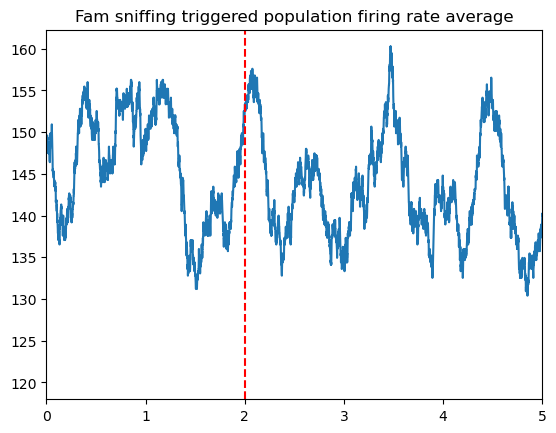

In [14]:
mean_arr = np.mean(fam_event_firingrates, axis=0)
sem_arr = sem(fam_event_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,5)
plt.title('Fam sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [88]:
cagemate_path ='.\\proc_old_backup\\20221219_141311_6_1_cagemate_merged.rec\\phy'
    
cagemate_timestamps, cagemate_clusters_array = get_spike_specs(cagemate_path)
cagemate_spiketrain = get_spiketrain(cagemate_timestamps, 20)

cagemate_sniffing_bouts = boris.get_behavior_bouts(cagemate_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
cagemateevent_firingrates = get_event_firing_rates(cagemate_sniffing_bouts, cagemate_timestamps, 2, 1, 20, 20000)


-0.69635 you are losing this many seconds of recording data
-0.69635 you are losing this many seconds of recording data


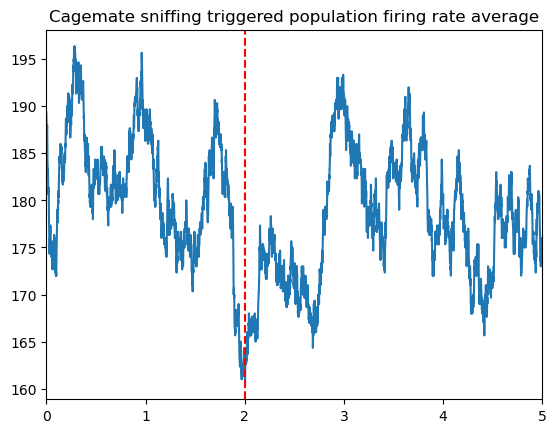

In [98]:
mean_arr = np.mean(cagemateevent_firingrates, axis=0)
sem_arr = sem(cagemateevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,5)
plt.title('Cagemate sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

-0.55855 you are losing this many seconds of recording data
-0.55855 you are losing this many seconds of recording data


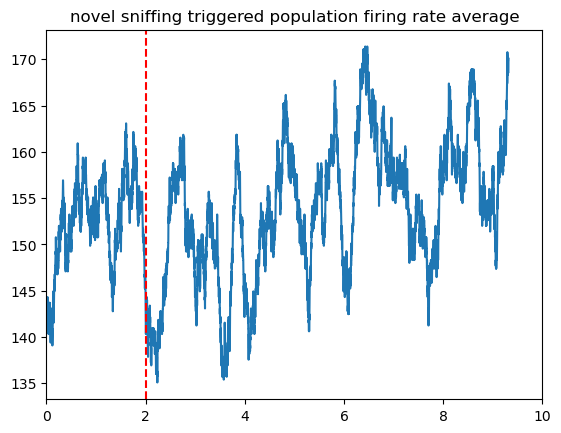

In [102]:
novel_path ='.\\proc_old_backup\\20221219_124942_6_1_novel_merged.rec\\phy'
    
novel_timestamps, novel_clusters_array = get_spike_specs(novel_path)
novel_spiketrain = get_spiketrain(novel_timestamps, 20)

novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
novelevent_firingrates = get_event_firing_rates(novel_sniffing_bouts, novel_timestamps, 2, 1, 20, 20000)    

mean_arr = np.mean(novelevent_firingrates, axis=0)
sem_arr = sem(novelevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,10)
plt.title('novel sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [12]:
x = np.array(range(len(fam_all_sniff)))
plt.figure(figsize = (25,5))
plt.ylim(0,35)
plt.plot(x, fam_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, fam_baseline_snippet, c = 'k', linewidth = .5)
plt.title('FAM', fontsize = 40)

x = np.array(range(len(novel_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, novel_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, novel_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Novel', fontsize = 40)

x = np.array(range(len(cagemate_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, cagemate_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, cagemate_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Cagemate', fontsize = 40)

NameError: name 'fam_all_sniff' is not defined

In [13]:
# Create the raster plot
plt.figure(figsize = (12,1))
plt.eventplot(spiketrain_array)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('Raster Plot')
plt.show()

NameError: name 'spiketrain_array' is not defined

<Figure size 1200x100 with 0 Axes>

In [14]:
fake_array = np.array([[1,4], [2,3]])
new_array = np.sort(fake_array.flatten())
print(fake_array)
print(new_array)

[[1 4]
 [2 3]]
[1 2 3 4]


In [15]:
reshaped_array = np.reshape(new_array*1000, (2,2))

In [16]:
reshaped_array

array([[1000, 2000],
       [3000, 4000]])

In [17]:
fake_data = [1,2,3,4,5]
fake_data.extend([1,2])
fake_data

[1, 2, 3, 4, 5, 1, 2]

In [18]:
nested_dict = {'a' : {'b' : [[2,3], [3,3]]}}
nested_dict['a']['b']

[[2, 3], [3, 3]]

In [19]:
empty_list = []
snif_bouts = [[1,2], [8,10]]
anogential_bouts = [[4,9]]
empty_list.append(snif_bouts)
empty_list.append(anogential_bouts)
bouts = np.concatenate(empty_list)

In [20]:
organizer = np.argsort(bouts[:,0])

In [21]:
bouts = bouts[organizer]

In [22]:
bouts

array([[ 1,  2],
       [ 4,  9],
       [ 8, 10]])

In [23]:
subject = ['mouse', 'mouse1']
'_'.join(subject)
    

'mouse_mouse1'

In [24]:
if type(subject) == list:
    print('yes')
else:
    print('no')

yes


In [25]:
subject = ['subject', 'cage mate']
behavior = ['face sniffing', 'anogenital sniffing']
if type(subject) == list:
    subject = '_'.join(subject)
if type(behavior) == list:
    behavior = '_'.join(behavior)
subject = subject.replace(" ", "")
behavior = behavior.replace(" ","")
filename = f"{subject}_{behavior}_bouts.npy"
print(filename)

subject_cagemate_facesniffing_anogenitalsniffing_bouts.npy


In [26]:
fake_array = np.array([1,2,3,4,5,6,7])
i = 3

fake_array = fake_array[i:]
fake_array

array([4, 5, 6, 7])

In [27]:
subject = 'mouse'
if type(subject) != list:
    subject = [subject]


In [28]:
print(subject)

['mouse']


In [29]:
arrays = []
one_nparray = np.array([[1,2],[1,3]])
#two_nparray = np.array([[1,2],[1,3]])
arrays.append(one_nparray)
#arrays.append(two_nparray)

In [30]:
len(arrays)

1

In [31]:
long_nparray = np.concatenate(arrays)
long_nparray

array([[1, 2],
       [1, 3]])

In [32]:
spiketrain = np.array([0,2,3,1,2,3,4,5,0,0,0,0,1,2,3,4,5,3,4,5,1,1,1,1,1,0,0,0,0,0,0,0])
smoothing_window = 3
timebin = 2

len(spiketrain)


32

In [33]:
if timebin != 1:
    current_timebin = 0
    temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
    for i in range(0, len(spiketrain), timebin):
        try:
            temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
            current_timebin += 1
        except IndexError:
            #should i pad here or just drop it? 
            temp_spiketrain[current_timebin] = sum(spiketrain[i:])
    spiketrain = temp_spiketrain

spiketrain


array([2., 4., 5., 9., 0., 0., 3., 7., 8., 9., 2., 2., 1., 0., 0., 0.])

In [34]:
len(spiketrain)

16

In [35]:
firing_rate = np.empty(len(spiketrain) - smoothing_window)
rolling_sum = sum(spiketrain[0:smoothing_window])
for i in range(len(firing_rate)):
    firing_rate[i] = rolling_sum / (smoothing_window * .001 * timebin)
    rolling_sum = rolling_sum - spiketrain[i] + spiketrain[i+smoothing_window]
firing_rate

array([1833.33333333, 3000.        , 2333.33333333, 1500.        ,
        500.        , 1666.66666667, 3000.        , 4000.        ,
       3166.66666667, 2166.66666667,  833.33333333,  500.        ,
        166.66666667])

In [36]:
labels_dict = {'1': 'good', '2': 'mua', '3':'good'}
spike_dict = {'1': np.array([2,4,5]), '2': np.array([1,3]), '3': np.array([0,6,7])}
recording_length = 10
unit_spiketrains = {}
for unit in spike_dict.keys():
    if labels_dict[unit] == 'good':
        unit_spiketrains[unit] = get_spiketrain(spike_dict[unit], recording_length, 1000)



0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]


In [37]:
unit_spiketrains

{'1': array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.]),
 '3': array([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])}

In [43]:
unit_firing_rates = {}
unit_spiketrains = get_unit_spiketrains(labels_dict, spike_dict, 10, 1000)
for unit in unit_spiketrains.keys():
    unit_firing_rates[unit] = get_firing_rate(spike_dict[unit], 10, 2, 2, 1000)

0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]
0 [2 4 5]
1 [2 4 5]
2 [2 4 5]
0 [0 6 7]
1 [0 6 7]
2 [0 6 7]


In [44]:
unit_firing_rates

{'1': array([250., 750., 500.,   0.]), '3': array([250.,   0., 500., 500.])}